Краткий обзор решения, получившего первое место на приватборде.
Сразу скажу, что данное решение не было в ключено в курсовой проект, из-за моих сомнений по поводу качества предсказаний на привате.

In [1]:
# грузим библиотеки:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline, Pipeline

from catboost import CatBoostClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

подцепляем доп.функции

In [2]:
# сравнение работы модели на тренировочной и валидационной выборках
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
        print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
        print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
        print('CONFUSION MATRIX\n')
        print(pd.crosstab(y_test_true, y_test_pred))
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [3]:
# просмотр значимых признаков для модели
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    if get_top is not None:
        feature_importances=feature_importances.sort_values('importance', ascending=False)[:get_top]
    else:          
        feature_importances = feature_importances.sort_values('importance', ascending=False)
    
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(x='importance', y='feature', data=feature_importances)
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold)), zero_division=1))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    #Determines cross-validated training and test scores for different training set sizes.
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
# функция просмотра основной информации по датасету:
def show_me_info(df):
    data=df.copy()
    mask=data.isnull()
    missing=mask.sum()
    missing_percent=mask.mean()*100
    data_types=data.dtypes
    unique_values=data.nunique()
    data=pd.concat([data.count(), missing, missing_percent, data_types, unique_values],
                   axis=1,
                   keys=['Total count','Total missing', 'Percent missing', 'Types', 'Unique values']).sort_values(
        by='Total missing', ascending=False)
    return data

загружаем данные

In [7]:
TRAIN_DATASET_PATH = '../input/654pds2courseproject/course_project_train.csv'
TEST_DATASET_PATH = '../input/654pds2courseproject/course_project_test.csv'

In [8]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

смотрим на данные

In [9]:
show_me_info(df_train)

,Total count,Total missing,Percent missing,Types,Unique values
Months since last delinquent,3419,4081,54.413333,float64,89
Credit Score,5943,1557,20.760000,float64,268
Annual Income,5943,1557,20.760000,float64,5478
Years in current job,7129,371,4.946667,object,11
Bankruptcies,7486,14,0.186667,float64,5
Purpose,7500,0,0.000000,object,15
Monthly Debt,7500,0,0.000000,float64,6716
Current Credit Balance,7500,0,0.000000,float64,6592
Current Loan Amount,7500,0,0.000000,float64,5386
Term,7500,0,0.000000,object,2


In [10]:
show_me_info(df_test)

,Total count,Total missing,Percent missing,Types,Unique values
Months since last delinquent,1142,1358,54.32,float64,83
Annual Income,1987,513,20.52,float64,1929
Credit Score,1987,513,20.52,float64,211
Years in current job,2414,86,3.44,object,11
Bankruptcies,2497,3,0.12,float64,6
Home Ownership,2500,0,0.00,object,4
Tax Liens,2500,0,0.00,float64,8
Number of Open Accounts,2500,0,0.00,float64,35
Years of Credit History,2500,0,0.00,float64,345
Maximum Open Credit,2500,0,0.00,float64,2435


Баланс целевой переменной:

In [11]:
TARGET_VAR='Credit Default'
df_train[TARGET_VAR].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

Видим, что про количеству пропущенных данных тренировочная и тестовая выборки схожи. Выборка несбалансирована, целевой класс встречается в 2,55 раза реже.

посмотрим на категориальные признаки, сравним их значения на трейне и на тесте:

In [12]:
cat_feature=df_train.select_dtypes(include='object').columns
for name in cat_feature:
    diff=list(set(df_test[name].unique())^set(df_train[name].unique()))
    print(f'Признак: {name: >20}\tРазличия в значениях: {", ".join(diff[i] for i in range(len(diff))) if len(diff)!=0 else "NO": >17}')

Признак:       Home Ownership	Различия в значениях:                NO
Признак: Years in current job	Различия в значениях:                NO
Признак:              Purpose	Различия в значениях:  renewable energy
Признак:                 Term	Различия в значениях:                NO


Посмотрим на распределения признаков, и посмотрим, удастся ли установить взаимосвязь между ними:

In [13]:
#рисует долго, раскомментируйте код
NUM_FEATURES=['Annual Income','Maximum Open Credit',  'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
#sns.pairplot(df_train[NUM_FEATURES+[TARGET_VAR]], hue=TARGET_VAR, dropna=True, diag_kind='hist')
#plt.show()

по факту в курсовой решил сдать достатоно простой вариант с быстрой моделью RandomForestClassifier, которая легко выдавала сопоставимые с более сложными моделями результаты, не требуя сложной от
бработки признаков.  
**И так:**  
* обработка признаков, деление на трейн и валидацию, погонка модели, итоги и выводы

In [14]:
class FeatureImputer1:
    count=0
    def __init__(self):
        self.count+=1
        
    
    def fit(self, X, y=None):
        self.dummy_col=['Home Ownership', 'Term', 'Years in current job_ord', 'Purpose_ord']
        self.purpose_change='vacation'
        self.ownership_change='Home Mortgage'
        self.dct={'unknow':0,
                  '< 1 year':1,
                  '1 year':2,
                  '2 years':3,
                  '3 years':4,
                  '4 years':5,
                  '5 years':6,
                  '6 years':7,
                  '7 years':8,
                  '8 years':9,
                  '9 years':10,
                  '10+ years':11}
        self.dct1={'business loan':0,
                   'buy a car':1,
                   'buy house':2,
                   'debt consolidation':3,
                   'educational expenses':4,
                   'home improvements':5,
                   'major purchase':6,
                   'medical bills':7,
                   'moving':8,
                   'other':9,
                   'small business':10,
                   'take a trip':11,
                   'vacation':12,
                   'wedding':13}
        self.drop_col=['Years in current job', 'Purpose']
        
        self.mean=int(X['Months since last delinquent'].mean())
        
        return self
    def transform(self, X):
        X_trans=X.copy()
        X_trans.loc[X_trans['Purpose']=='renewable energy', 'Purpose']=self.purpose_change # приводим в соответствие разницу в значениях на трейне и тесте
        X_trans.loc[X_trans['Home Ownership']=='Have Mortgage', 'Home Ownership']=self.ownership_change # "сливаем" ипотечников вместе
        X_trans['Years in current job'].fillna('unknow', inplace=True) # заполняем пропуски по стажу работы
        X_trans.insert(2,'Years in current job_ord',X_trans['Years in current job'].map(self.dct)) # one-hot кодируем стаж
        X_trans.insert(X_trans.columns.get_loc('Purpose')+1,'Purpose_ord',X_trans['Purpose'].map(self.dct1)) # one-hot кодируем цель кредиттования
        X_trans.drop(self.drop_col, axis=1, inplace=True)
        
        X_trans.loc[(X_trans['Annual Income'].notna())&(X_trans['Months since last delinquent'].isna()), 'Months since last delinquent']=self.mean # заменяем пропуски на среднее
        
        X_trans.fillna(0, inplace=True) # остальные пропуски заменяем 0
        X_trans=pd.get_dummies(X_trans, columns=self.dummy_col, drop_first=True) # все категориальные признаки dummy-кодируем

        return X_trans

In [15]:
train, val = train_test_split(df_train,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df_train[TARGET_VAR],
                               random_state=12)

In [16]:
imputer=FeatureImputer1()
train=imputer.fit(train).transform(train)
val=imputer.transform(val)

In [17]:
X_train, y_train, X_val, y_val = train.drop(TARGET_VAR, axis=1), train[TARGET_VAR], val.drop(TARGET_VAR, axis=1), val[TARGET_VAR]

In [18]:
%%time
rfc=RandomForestClassifier(max_depth=4, class_weight={0:1,1:2.55}, random_state=100)
rfc.fit(X_train, y_train)
evaluate_preds(rfc, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      4310
           1       0.49      0.67      0.56      1690

    accuracy                           0.71      6000
   macro avg       0.67      0.70      0.67      6000
weighted avg       0.75      0.71      0.72      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1077
           1       0.45      0.62      0.52       423

    accuracy                           0.68      1500
   macro avg       0.64      0.66      0.64      1500
weighted avg       0.72      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               759  318
1               160  263
CPU times: user 560 ms, sys: 3.39 ms, total: 563 ms
Wall time: 565 ms


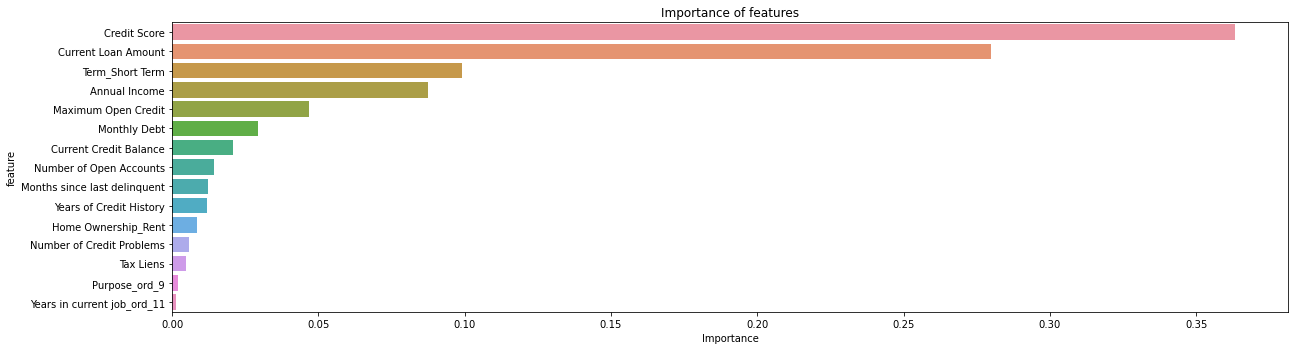

In [19]:
important_features_top = show_feature_importances(X_train.columns,
                                                  rfc.feature_importances_, get_top=15)

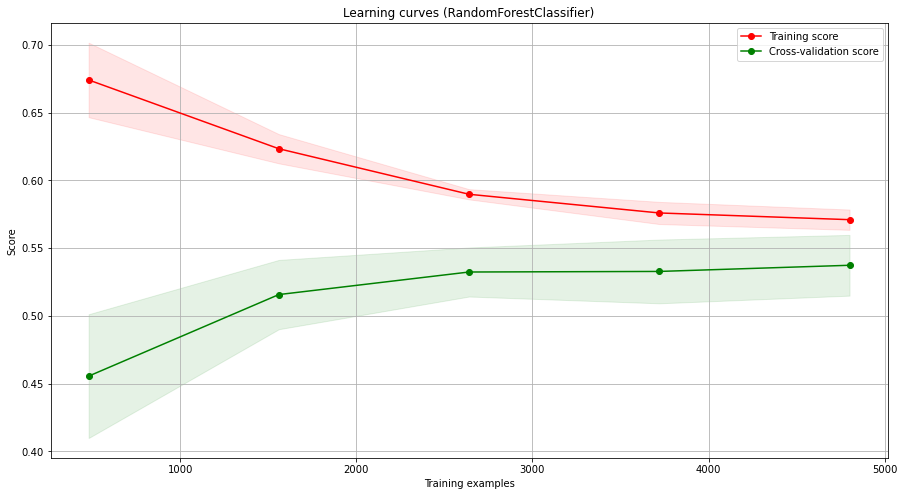

In [20]:
show_learning_curve_plot(rfc, X_train, y_train)

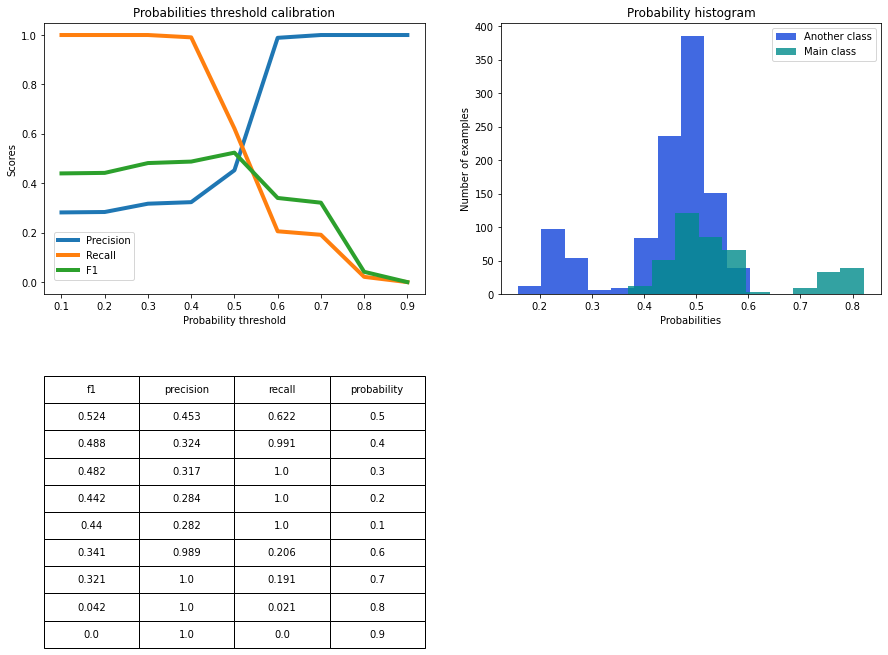

In [21]:
y_val_pred=rfc.predict_proba(X_val)
show_proba_calibration_plots(y_val_pred[:, 1], y_val)

Данная модель выдала **0.57032** на паблике и **0.52695** на привате, однако по результатам паблика была сдана как основная.

***

### Отступление № 0, на тему "Почему в итоге не выбрана эта модель?":

однако-показатель паблика как правило является для нас самым существенным индикатором качества проделанной работы, поэтому поиск наилучшей модели продолжался.

Т.к. надо заполнять пропуски в "Annual Income" решил посмотреть как этот признак связан с остальными. Для начала построил матрицу корреляции:

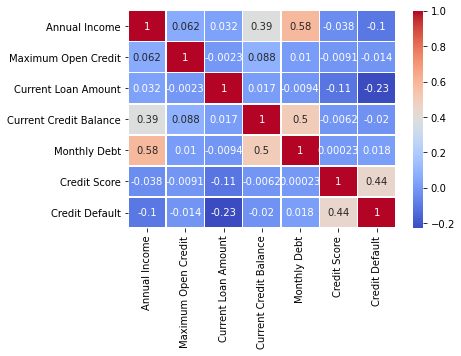

In [22]:
sns.heatmap(df_train[NUM_FEATURES+[TARGET_VAR]].corr(), annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

решил посмотреть на связь с "Mounthly Debt":

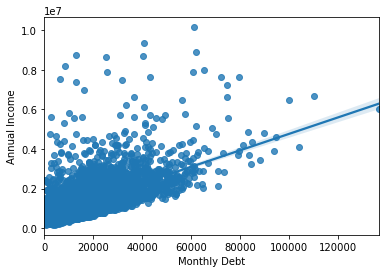

In [23]:
sns.regplot(x=df_train['Monthly Debt'], y=df_train['Annual Income'], dropna=True)
plt.show()

выглядит относительно неплохо. решил посмотреть на линейную зависимость "Annual Income" от "Mounthly Debt":

первый способ, через библиотеку scipy:  

нужны  данные без пропусков

In [24]:
dfstat=df_train[["Annual Income","Monthly Debt"]].dropna(axis=0)

Находим коэффициенты линейной регрессии

In [25]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dfstat['Monthly Debt'], dfstat['Annual Income'])

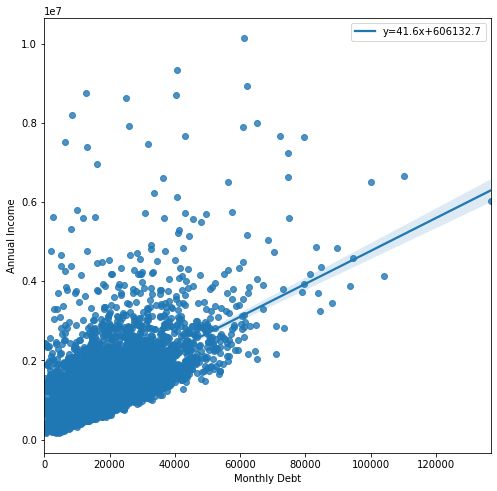

In [26]:

plt.figure(figsize=(8,8))
# use line_kws to set line label for legend
ax=sns.regplot(x=df_train['Monthly Debt'], y=df_train['Annual Income'], line_kws={'label':f"y={slope:.1f}x+{intercept:.1f}"})
ax.legend()

plt.show()

всё вроде красиво. Но, надо бы проверить стат-гипотезу  о наличии линейной связи

пользуемся statmodel

In [27]:
statmodel=df_train[NUM_FEATURES+[TARGET_VAR]]
columns=statmodel.columns.tolist()
for i in range(len(columns)):
    columns[i]='_'.join(columns[i].split()[j] for j in range(len(columns[i].split())))
statmodel.columns=columns

In [28]:
model = ols('Annual_Income~Monthly_Debt',data=statmodel).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Annual_Income   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     3088.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:54:31   Log-Likelihood:                -88296.
No. Observations:                5943   AIC:                         1.766e+05
Df Residuals:                    5941   BIC:                         1.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.061e+05   1.63e+04     37.143      0.000    5.74e+05    6.38e+05
Monthly_Debt    41.5927      0.748     55.570      0.000      40.125      43.060
==============================================================================
Omnibus:                     4685.087   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148325.936
Skew:                           3.538   Prob(JB):                         0.00
Kurtosis:                      26.429   Cond. No.                     4.00e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

видим, что гипотеза о неравенстве коэффициентов 0 подтвердилась. и 34% дисперсии "Annual Income" объясняется дисперсией "Monthly Debt". Можно принимать гипотезу о наличии линейной связи между этими признаками, и пытаться восстановить пропуски по "Annual Income".  
в данном варианте **ИМЕННО** это легло в основу обработки пропусков по этому признаку

### Отступление № 1, на тему "Почему в итоге не выбрана эта модель?":

*но, когда выбирался  вариант для курсового, возникли сомнения, все ли условия соблюдены. начал проверять условия применимости линейной регрессии.*

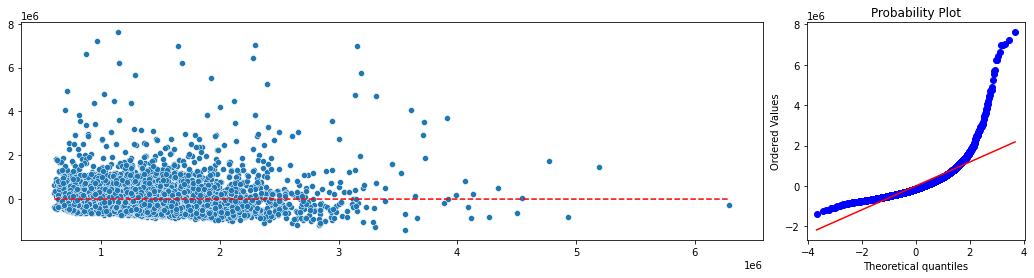

In [29]:
y_pred=model.predict(statmodel)
fig=plt.figure(figsize=(18,4))
gs = fig.add_gridspec(1, 4)
ax1 = fig.add_subplot(gs[0, :-1])
sns.scatterplot(x=y_pred, y=model.resid)
sns.lineplot(x=y_pred, y=0, color='r', linestyle='dashed')
ax2=fig.add_subplot(gs[0, -1])
stats.probplot(model.resid, dist="norm", plot=sns.mpl.pyplot) # y-y_pred=model.resid
plt.show()

*на основании изучения остатков(отклонений) сделал вывод что:"Так как явно не соблюдается гомоскедастичность остатков и нормальность их распределения-то использовать результаты линейной регрессии для заполнения пропусков в графе 'Annual Income' мы не можем."*

***

Так же при исследовании датасета было замечено, что значения 'Credit Score' > 6000, и 'Current Loan Amount' >= 99999999.0, хоть и не являются типичными, но явно отделяют часть классов.

В итоге, в результате изучения признаков было решено не избавляться от пропусков, и появился следующий вариант подготовки данных:

In [30]:
class FeatureImputer2:
    
    def __init__(self):
        self.bancrupties=None
        
    def fit(self, X, y=None):
        self.bancrupties=0
        self.purpose_change='vacation'
        self.ho_change='Home Mortgage'
        self.cat_features=X.select_dtypes(include='object').columns.tolist()
        self.dcts=[{'Own Home':0,
                   'Rent':1,
                   'Home Mortgage':2                    
                   },
                   {'unknow':0,
                    '< 1 year':1,
                    '1 year':2,
                    '2 years':3,
                    '3 years':4,
                    '4 years':5,
                    '5 years':6,
                    '6 years':7,
                    '7 years':8,
                    '8 years':9,
                    '9 years':10,
                    '10+ years':11
                   },
                   {'business loan':0,
                    'buy a car':1,
                    'buy house':2,
                    'debt consolidation':3,
                    'educational expenses':4,
                    'home improvements':5,
                    'major purchase':6,
                    'medical bills':7,
                    'moving':8,
                    'other':9,
                    'small business':10,
                    'take a trip':11,
                    'vacation':12,
                    'wedding':13
                   },
                   {'Short Term':0,
                    'Long Term':1
                   }]
        return self
        
        
    def transform(self,X):
        X_trans=X.copy()
        X_trans['Bankruptcies'].fillna(self.bancrupties, inplace=True) # пропуски по 'Bankruptcies'заполняем 0
        X_trans['Annual Income'].fillna(X_trans['Monthly Debt']*41.5+606100, inplace=True) #пропуски по 'Annual Income'заполняем по полученной линейной зависимости
        X_trans.loc[X_trans['Purpose']=='renewable energy', 'Purpose']=self.purpose_change # приводим в соответствие разницу в значениях на трейне и тесте
        X_trans.loc[X_trans['Home Ownership']=='Have Mortgage', 'Home Ownership']=self.ho_change # "сливаем" ипотечников вместе
        X_trans['Years in current job'].fillna('unknow', inplace=True) # заполняем пропуски по стажу работы
        self.cat_feat=[]
        for num, column in enumerate(self.cat_features): # label-кодирование категориальных признаков
            X_trans.insert(X_trans.columns.get_loc(column)+1,column+'_ord',X_trans[column].map(self.dcts[num]))
            self.cat_feat.append(column+'_ord')
            X_trans=X_trans.drop(column, axis=1)
        X_trans['Current Loan Amount_outline']=0 # отмечаем выбросы по 'Current Loan Amount'
        X_trans.loc[X_trans['Current Loan Amount']>90000000, 'Current Loan Amount_outline']=1
        X_trans['Credit score_outline']=0 # отмечаем выбросы по 'Credit Score'
        X_trans.loc[X_trans['Credit Score']>5000, 'Credit score_outline']=1
        X_trans.loc[X_trans['Credit Score'].isna(), 'Credit Score']=0
        X_trans['Months since last delinquent_outline']=0 # отмечаем выбросы(пропуски) по 'Months since last delinquent'
        X_trans.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent_outline']=1
        X_trans['Months since last delinquent'].fillna(-1, inplace=True)
        return X_trans

Приступаем к обучению, делим данные для обучения на тренировочную и валидационную:

In [31]:
train, val = train_test_split(df_train,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df_train[TARGET_VAR],
                               random_state=12)

обрабатываем данные:

In [32]:
imputer=FeatureImputer2()
train=imputer.fit(train).transform(train)
val=imputer.transform(val)

In [33]:
X_train, y_train, X_val, y_val = train.drop(TARGET_VAR, axis=1), train[TARGET_VAR], val.drop(TARGET_VAR, axis=1), val[TARGET_VAR]

В качестве модели был подобран CatBoostClassifier со следующими параметрами:  

категориальные признаки

In [34]:
categ=['Home Ownership_ord', 'Years in current job_ord', 'Purpose_ord', 'Term_ord']

параметры модели

In [35]:
frozen_params1 = {'silent': True,
                 'random_state': 42,
                 'depth': 4, 
                 'iterations': 550, 
                 'learning_rate': 0.2,
                 'eval_metric': 'F1',
                 'class_weights': [1, 2.55],
                 'early_stopping_rounds': 500,
                 'cat_features': categ
                }

обучаем модель:

In [36]:
cat_model = CatBoostClassifier(**frozen_params1)

cat_model.fit(X_train, y_train, categ, eval_set=(X_val, y_val))

смотрим итоги

In [37]:
evaluate_preds(cat_model, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      4310
           1       0.50      0.67      0.57      1690

    accuracy                           0.72      6000
   macro avg       0.68      0.70      0.68      6000
weighted avg       0.75      0.72      0.73      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.70      0.76      1077
           1       0.46      0.65      0.54       423

    accuracy                           0.69      1500
   macro avg       0.65      0.68      0.65      1500
weighted avg       0.73      0.69      0.70      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               757  320
1               146  277


Всё вроде хорошо(хотя RandomForest показывает схожие результаты)
Вот итоги сданного проекта:  

`TRAIN`

             `precision    recall  f1-score   support`  

          `0       0.85      0.73      0.78      4310`  
          `1       0.49      0.67      0.56      1690`  

    `accuracy                          0.71      6000`  
   `macro avg      0.67      0.70      0.67      6000`  
`weighted avg      0.75      0.71      0.72      6000`  

`TEST`  

             `precision    recall  f1-score   support`  

          `0       0.83      0.70      0.76      1077`  
          `1       0.45      0.62      0.52       423`  

    `accuracy                          0.68      1500`  
   `macro avg      0.64      0.66      0.64      1500`  
`weighted avg      0.72      0.68      0.69      1500`  

`CONFUSION MATRIX`  

`col_0             0    1`  
`Credit Default          `  
`0               759  318`  
`1               160  263`  
`Wall time: 407 ms`


Смотрим основные признаки для модели:

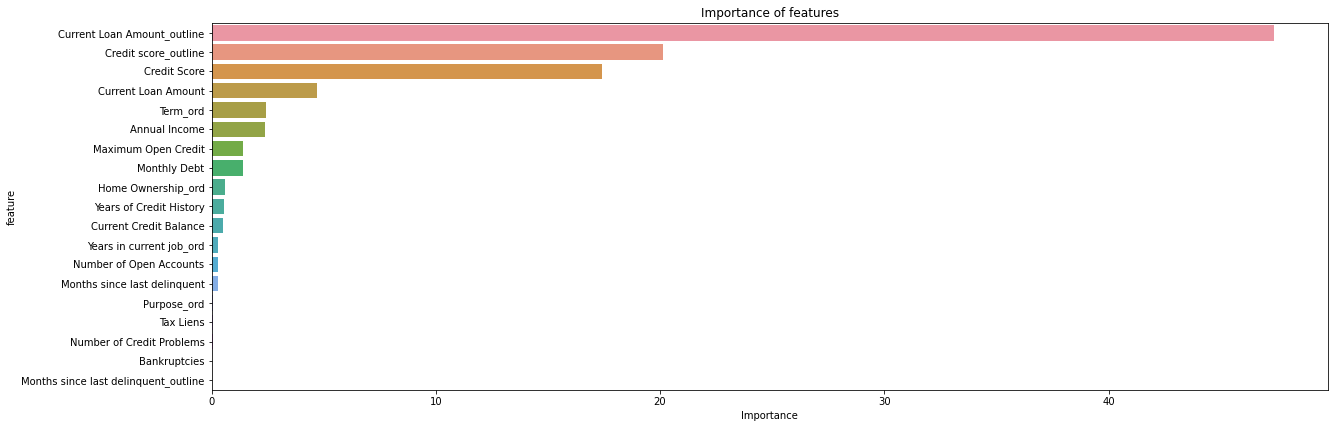

In [38]:
important_features_top = show_feature_importances(X_train.columns,
                                                  cat_model.feature_importances_)

### Отступление № 2, на тему "Почему в итоге не выбрана эта модель?":

посмотрим на кривые обучения модели

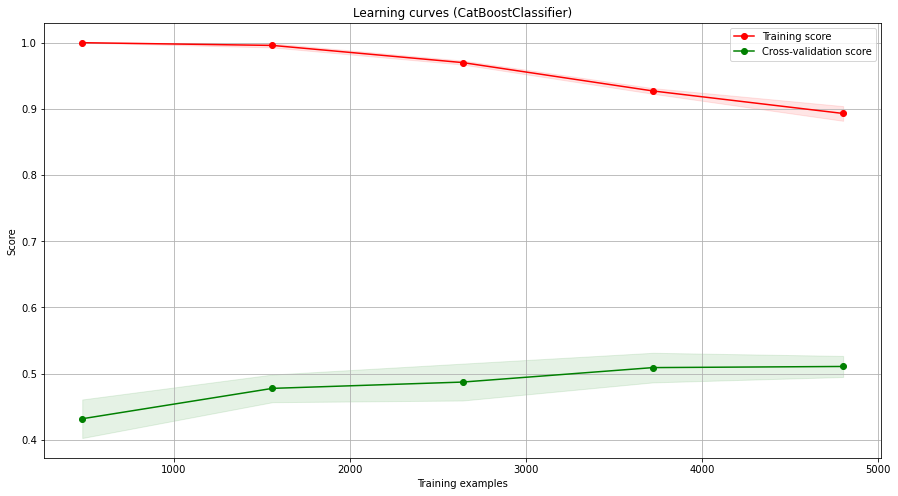

In [39]:
show_learning_curve_plot(cat_model, X_train, y_train)

Вот эта разница в между трейном и кросс-валидацией тоже смущает.

Вот так это выглядело на RandomForest...Правда логичнее?
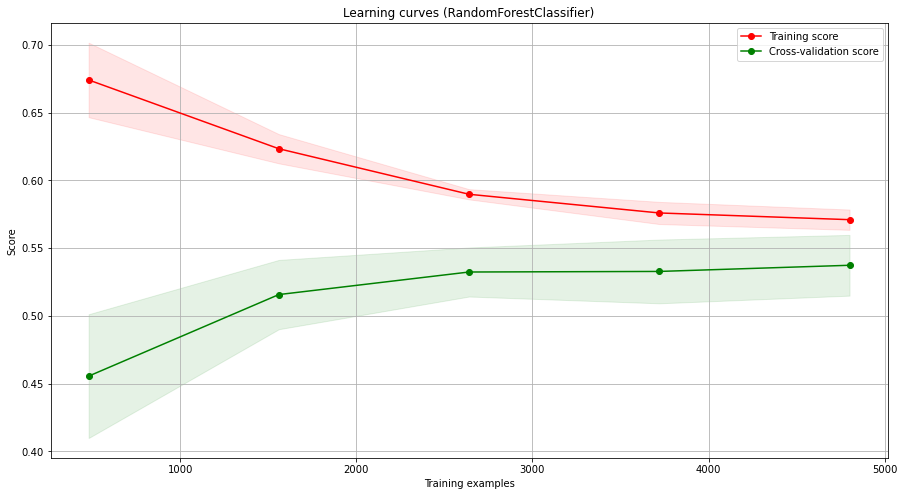

смотрим на trashhold calibration

In [40]:
y_val_pred=cat_model.predict_proba(X_val)

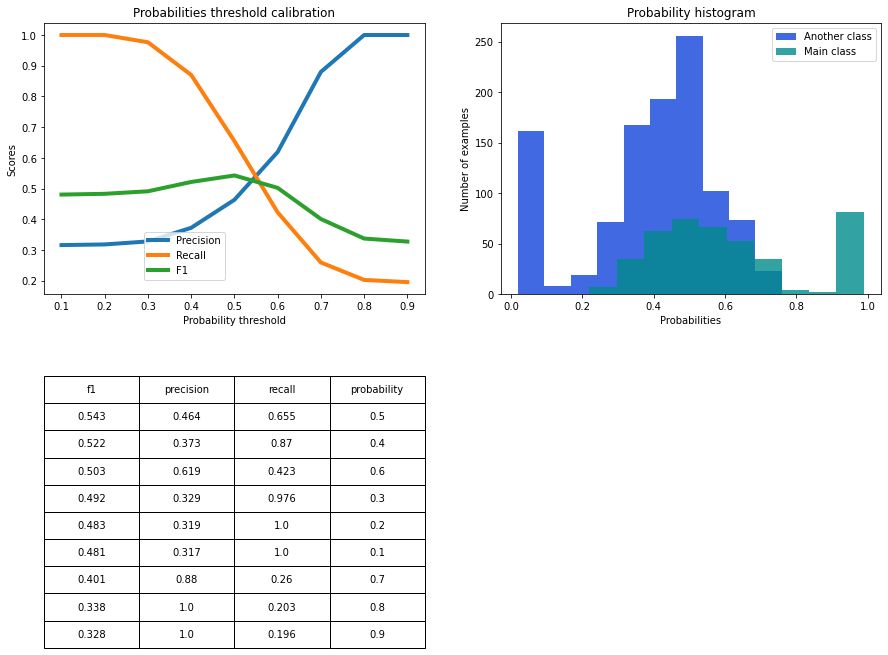

In [41]:
show_proba_calibration_plots(y_val_pred[:, 1], y_val)

сравним с результатами RandomForest..

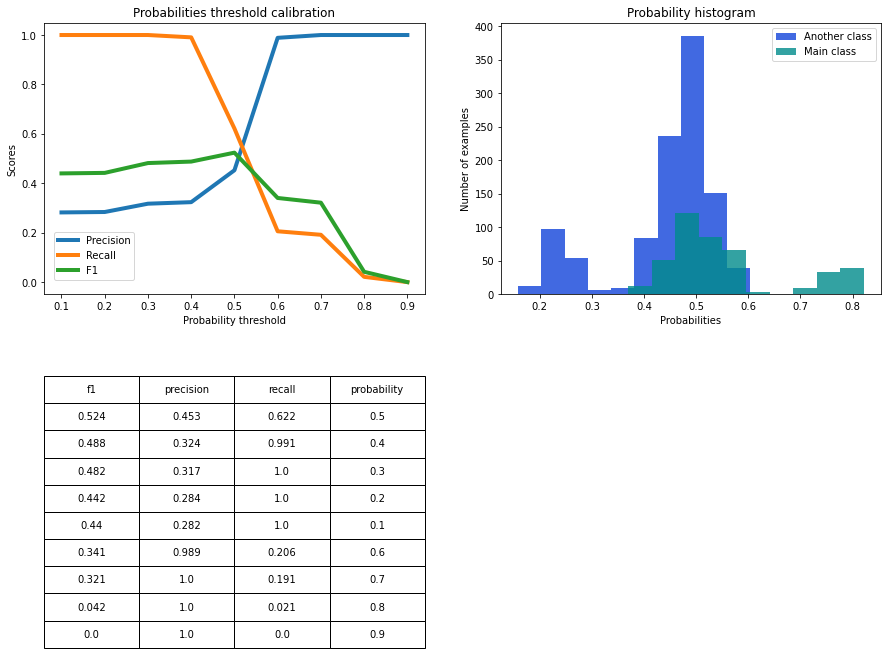

по итогам, данная модель выдала классные **0.58153** на паблике(3-е место) и **0.52613** на привате, немного(и ожидаемо) уступив RandomForest-у

***

Однако, в поисках решения задачи мы перебираем множество вариантов, и иногда некоторые из них, отвергнутые нами в процессе исследований, могут выдать нам удивительный результат(не смотря на то, что мы совершаем ошибку **первого рода**, принимая альтернативную гипотезу, при верности нулевой гипотезы...)

таким образом, проанализировав, какое именно из решений привело к лучшему скору на привате я обнаружил неожиданный для себя результат...

во первых был немного изменен преобразователь признаков, и категориальные признаки  были трансформированы по принципу dummy - кодирования

In [42]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [43]:
class FeatureImputer3:
    
    def __init__(self):
        self.bancrupties=None
        
    def fit(self, X, y=None):
        self.bancrupties=0
        self.purpose_change='vacation'
        self.ho_change='Home Mortgage'
        self.cat_features=X.select_dtypes(include='object').columns.tolist()
        self.dcts=[{'Own Home':0,
                   'Rent':1,
                   'Home Mortgage':2                    
                   },
                   {'unknow':0,
                    '< 1 year':1,
                    '1 year':2,
                    '2 years':3,
                    '3 years':4,
                    '4 years':5,
                    '5 years':6,
                    '6 years':7,
                    '7 years':8,
                    '8 years':9,
                    '9 years':10,
                    '10+ years':11
                   },
                   {'business loan':0,
                    'buy a car':1,
                    'buy house':2,
                    'debt consolidation':3,
                    'educational expenses':4,
                    'home improvements':5,
                    'major purchase':6,
                    'medical bills':7,
                    'moving':8,
                    'other':9,
                    'small business':10,
                    'take a trip':11,
                    'vacation':12,
                    'wedding':13
                   },
                   {'Short Term':0,
                    'Long Term':1
                   }]
        return self
        
        
    def transform(self,X):
        X_trans=X.copy()
        X_trans['Bankruptcies'].fillna(self.bancrupties, inplace=True)
        X_trans['Annual Income'].fillna(X_trans['Monthly Debt']*41.5+606100, inplace=True)
        X_trans.loc[X_trans['Purpose']=='renewable energy', 'Purpose']=self.purpose_change
        X_trans.loc[X_trans['Home Ownership']=='Have Mortgage', 'Home Ownership']=self.ho_change
        X_trans['Years in current job'].fillna('unknow', inplace=True)
        new_cat_col=[]
        for num, column in enumerate(self.cat_features):
            X_trans.insert(X_trans.columns.get_loc(column)+1,column+'_ord',X_trans[column].map(self.dcts[num]))
            new_cat_col.append(column+'_ord')
            X_trans=X_trans.drop(column, axis=1)
        X_trans['Current Loan Amount_outline']=0
        X_trans.loc[X_trans['Current Loan Amount']>90000000, 'Current Loan Amount_outline']=1
        X_trans['Credit score_outline']=0
        X_trans.loc[X_trans['Credit Score']>5000, 'Credit score_outline']=1
        X_trans.loc[X_trans['Credit Score'].isna(), 'Credit Score']=0
        X_trans['Months since last delinquent_outline']=0
        X_trans.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent_outline']=1
        X_trans['Months since last delinquent'].fillna(-1, inplace=True)
        X_trans=pd.get_dummies(X_trans, columns=new_cat_col, drop_first=True) # к предыдущему варианту добавилась эта строка
        return X_trans

In [44]:
train, val = train_test_split(df_train,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df_train[TARGET_VAR],
                               random_state=12)

In [45]:
imputer3=FeatureImputer3()
train=imputer3.fit(train).transform(train)
val=imputer3.transform(val)

In [46]:
X_train, y_train, X_val, y_val = train.drop(TARGET_VAR, axis=1), train[TARGET_VAR], val.drop(TARGET_VAR, axis=1), val[TARGET_VAR]

In [47]:
frozen_params1 = {'silent': True,
                 'random_state': 100,
                 'eval_metric': 'F1',
                 'class_weights': [1, 2.55],
                 'early_stopping_rounds': 100,
                 'depth': 5,
                 'iterations': 100,
                 'learning_rate': 0.1                 
                 }

In [48]:
cat_model = CatBoostClassifier(**frozen_params1)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

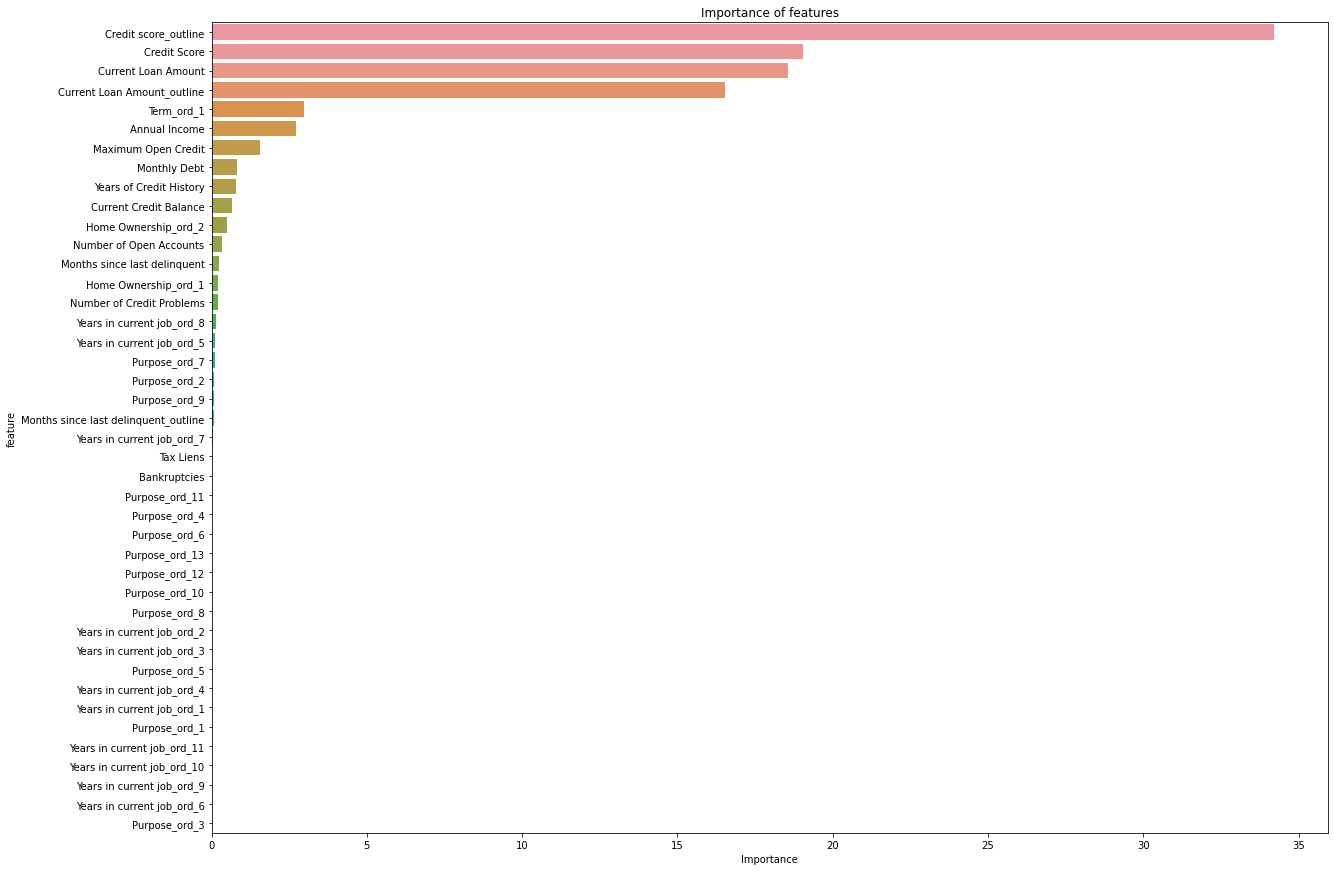

In [49]:
important_features_top = show_feature_importances(X_train.columns,
                                                  cat_model.feature_importances_)

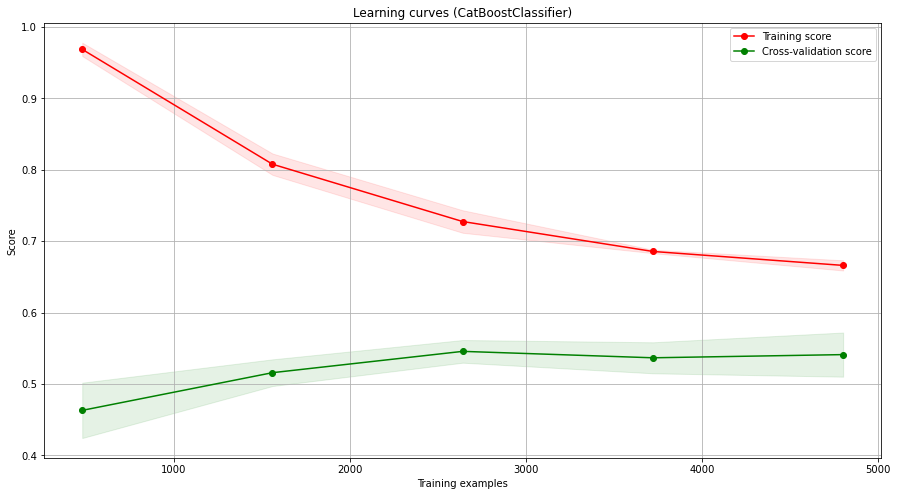

In [50]:
show_learning_curve_plot(cat_model, X_train, y_train)

In [51]:
y_val_pred=cat_model.predict_proba(X_val)

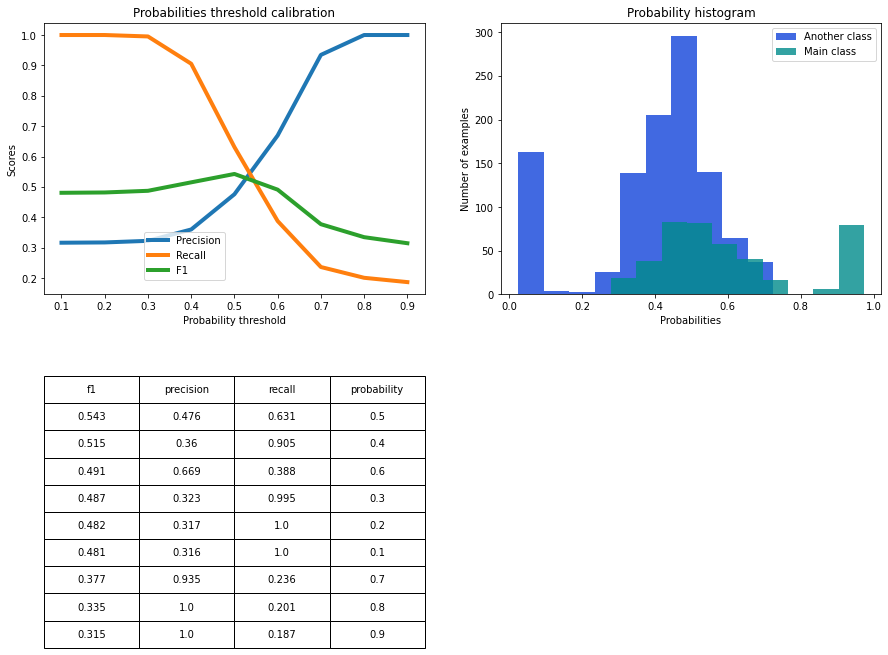

In [52]:
show_proba_calibration_plots(y_val_pred[:, 1], y_val)

Этот вариант даёт **0.56920** на паблике и **0.54593** на привате

В  итоге, как оказалось, из этих вариантов можно собрать VotingClassifier, который даст итоговый выигрышный результат на привате...

перед этим соберём пайплайн:

In [53]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [54]:
train, val = train_test_split(df_train,
                               test_size=0.2,
                               shuffle=True,
                               stratify=df_train[TARGET_VAR],
                               random_state=12)

In [55]:
X_train, y_train, X_val, y_val = train.drop(TARGET_VAR, axis=1), train[TARGET_VAR], val.drop(TARGET_VAR, axis=1), val[TARGET_VAR]

Для RandomForestClassifier применим первую модель, а для Catboost преобразуем признаки при помощи  FeatureImputer3()  
И объединим все в общий пайплайн

In [56]:
imp1=FeatureImputer1()
rfc=RandomForestClassifier(max_depth=5, class_weight={0:1,1:2.55}, random_state=100)
rf_pipe=Pipeline([('imputer', imp1), ('rfc',rfc)])
imp2=FeatureImputer3()
cbc=CatBoostClassifier(silent=True, class_weights={0:1,1:2.55}, learning_rate=0.005, random_seed=100, depth=5)
cbc_pipe=Pipeline([('imputer', imp2), ('cbc',cbc)])

Обучим модель

In [57]:
vclf = VotingClassifier(estimators=[('p1', rf_pipe), ('p2', cbc_pipe)], voting='soft')
vclf.fit(X_train, y_train)
evaluate_preds(vclf, X_train, X_val, y_train, y_val)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.75      0.80      4310
           1       0.53      0.71      0.61      1690

    accuracy                           0.74      6000
   macro avg       0.70      0.73      0.71      6000
weighted avg       0.77      0.74      0.75      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1077
           1       0.47      0.64      0.54       423

    accuracy                           0.69      1500
   macro avg       0.65      0.68      0.65      1500
weighted avg       0.73      0.69      0.71      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               771  306
1               154  269


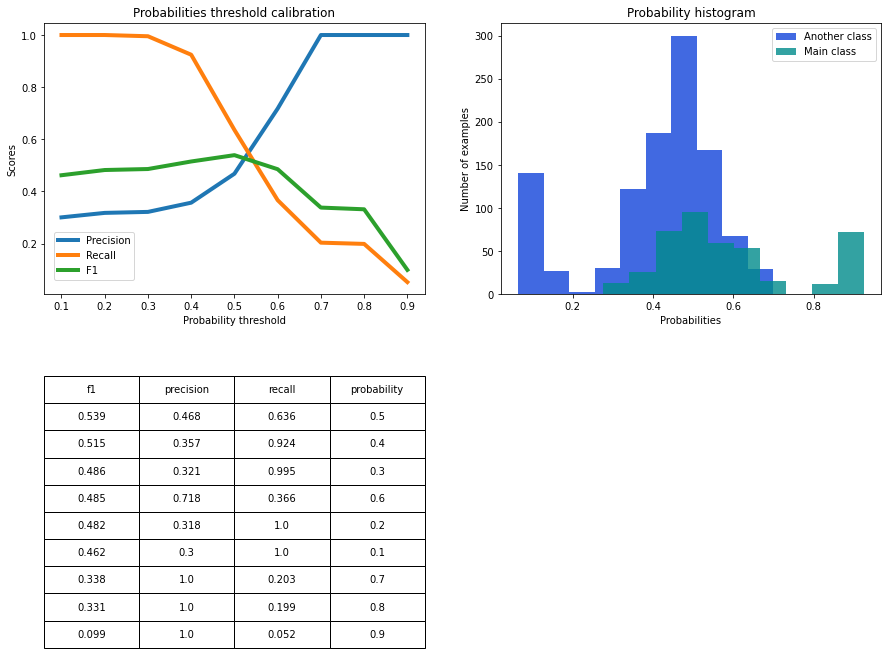

In [58]:
y_val_pred=vclf.predict_proba(X_val)
show_proba_calibration_plots(y_val_pred[:, 1], y_val)

делаем предсказания:

In [59]:
y_pred=vclf.predict(df_test)
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred})

In [60]:
RESULT_PATH='./vklf_mix_solutions.csv'
result.to_csv(RESULT_PATH, index=False)